In [1]:
import sys
import subprocess
import os
import glob
import numpy as np
import pandas as pd
import altair as alt
from PIL import Image

from gcnSurrogate.models.feastnetSurrogateModel import FeaStNet
from gcnSurrogate.readers.loadConmechGraphs import loadConmechGraphs
from gcnSurrogate.visualization.altTrussViz import plotTruss, interactiveErrorPlot
from gcnSurrogate.visualization.figureSaver import *
from gcnSurrogate.util.gcnSurrogateUtil import *

# fontStr = 'Times New Roman'
fontStr = 'Arial'

def fontStyle():
    return {
        "config" : {
             "title": {'font': fontStr},
             "axis": {
                  "labelFont": fontStr,
                  "titleFont": fontStr
             },
            'text': {'font': fontStr},
             'legend': {'labelFont': fontStr, 'titleFont': fontStr}, 
        }
    }

alt.themes.register('fontStyle', fontStyle)
alt.themes.enable('fontStyle')

COLW = 3.5625*500

alt.Chart({'values': [{"text": 'testing'}]}).mark_text(text='text', size=200).properties(width=200, height=200)

alt.Chart(...)

# correct sizing tests - concatenated plots

(1781, 1781)


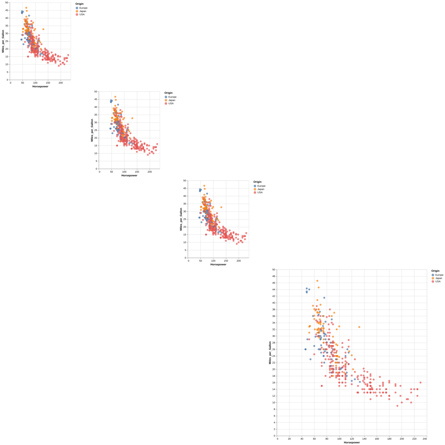

In [2]:
from vega_datasets import data
source = data.cars()

w = COLW/5 # five plots

# build charts
c1 = alt.Chart(source).mark_circle(size=60).encode(
    x=alt.X('Horsepower', ),
    y='Miles_per_Gallon',
    color=alt.Color('Origin'),
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).properties(width=2*w, height=2*w)
c1.autosize = autosize=alt.AutoSizeParams(contains='padding', type='fit')

c2 = alt.Chart(source).mark_circle(size=60).encode(
    x=alt.X('Horsepower', ),
    y='Miles_per_Gallon',
    color=alt.Color('Origin'),
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).properties(width=w, height=w)
c2.autosize = alt.AutoSizeParams(contains='padding', type='fit')

# build figure
chartData = [[c2,[w*i,w*i]] for i in range(3)]
chartData.append([c1, [w*3,w*3]])
chartsToFigure(chartData, figName='myFig01', baseDir='figures', canvasSize=[COLW, COLW])

(1781, 1318)


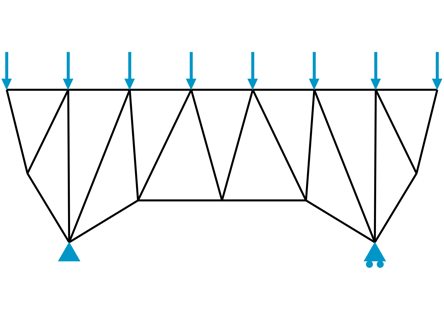

In [10]:
allGraphs = loadConmechGraphs('data/2D_Truss_v1.3/conmech/param_sweep_0_7_N_5/')
graph = allGraphs[0]
truss = plotTruss(allGraphs[0], width=COLW, lineWidth=8, showSupports=True, showLoads=True, loadSize=1e4, supportSize=3e4, domY=[-27,10])
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='trussLoads', baseDir='figures')

/data/anaconda/envs/ptgeom/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'gcnSurrogate.models.feastnetSurrogateModel.FeaStNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


(1781, 1318)


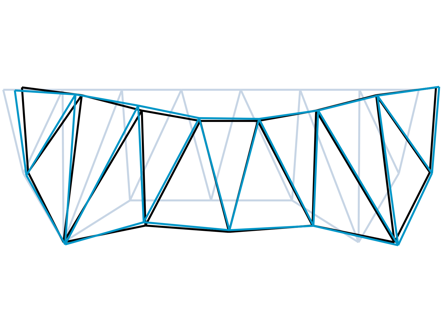

In [11]:
gcn = FeaStNet()
gcn.loadModel('results/gcn01/checkpoint_94')
preds = gcn.predict([graph])[0]
truss = plotTruss(graph, showDeformed=True, defScale=200, width=COLW, lineWidth=8, loadSize=1e4, supportSize=3e4, domY=[-27,10], prediction=preds)
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='trussPred', baseDir='figures')

# Design space and loading conditions

loading from data/2D_Truss_v1.3/conmech/param_sweep_0_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_1_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_2_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_3_7_N_5/
loading from data/2D_Truss_v1.3/conmech/param_sweep_4_7_N_5/
(1781, 1401)


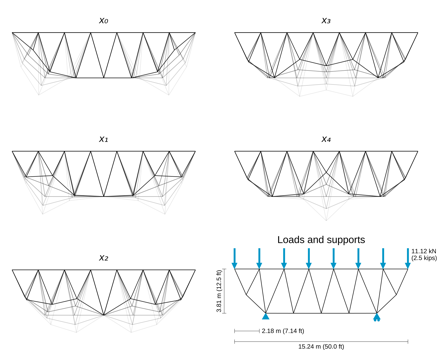

In [71]:
sweepDirs = glob.glob('data/2D_Truss_v1.3/conmech/param_sweep*/')
width = COLW/2
fontSize = 40
yOffset = -20
xOffset = -30
pad = 10
domX = [-5,55]
domY = [-22,0+pad]
rangeX = domX[1]-domX[0]
rangeY = domY[1]-domY[0]
height = width*rangeY/rangeX  # should guarentee equal aspect ratio

# sweep plots
chartData = []
for i,dataDir in enumerate(np.sort(sweepDirs)):
    print(f'loading from {dataDir}')
    allGraphs = loadConmechGraphs(dataDir)

    opacities = np.linspace(0.1,0.6,5)
    opacities[-1] = 1
    plotList = [plotTruss(g, withoutConfigure=True, 
                          lineOpacity=o, 
                          domX=domX, 
                          domY=domY, 
                          width=width) for g,o in zip(allGraphs, opacities)]
    
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    sweepPlot = alt.layer(*plotList, title=alt.TitleParams(
        f'x{i}'.translate(SUB), 
        fontSize=fontSize, 
        fontStyle='italic', 
        dy=120, 
        fontWeight='normal')).configure_view(strokeOpacity=0)
    sweepPlot.autosize = alt.AutoSizeParams(contains='padding', type='fit')
    
    r,c = i%3, i//3
    chartData.append([sweepPlot, [c*width+xOffset,r*height+yOffset]])

# support conditions
i += 1
r,c = i%3, i//3
nomDesign = plotTruss(allGraphs[2], 
                      withoutConfigure=True, 
                      domX=domX, 
                      domY=domY, 
                      width=width,
                      showLoads=True,
                      showSupports=True).properties(title='Loads and supports').configure_title(
    fontSize=fontSize, 
    dy=50, 
    fontWeight='normal')

# dimensions
dimX, dimY = allGraphs[2].pos.numpy().ptp(axis=0)
force = 2.5
flg = 0.6
h1 = -dimY-8
h2 = -dimY-5
w1 = -3
nLines = 9
dfLines = pd.DataFrame({'line':np.linspace(0,nLines-1,num=nLines).repeat(2), 'point':['start', 'end']*nLines})
dfLines.loc[dfLines.point=='start', 'x'] = [0,0,dimX]+         [w1,w1-flg,w1-flg]+ [0,0,dimX/7]
dfLines.loc[dfLines.point=='end', 'x'] =   [dimX,0,dimX]+      [w1,w1+flg,w1+flg]+ [dimX/7,0,dimX/7]
dfLines.loc[dfLines.point=='end', 'y'] =   [h1,h1+flg,h1+flg]+ [0,0,-dimY]+        [h2,h2+flg,h2+flg]
dfLines.loc[dfLines.point=='start', 'y'] = [h1,h1-flg,h1-flg]+ [-dimY,0,-dimY]+    [h2,h2-flg,h2-flg]

dims = alt.Chart(dfLines).mark_line(color='#000000', strokeWidth=1.0).encode(
    x=alt.X('x:Q'),
    y=alt.Y('y:Q'),
    detail='line')

dimLabelX = alt.Chart(pd.DataFrame({"text": f'{dimX*0.3048} m ({dimX} ft)', 'x':[dimX/2], 'y':[h1]}, index=[0])).mark_text(
    size=25, align='center', baseline='top', dy=8, opacity=1.0).encode(
    x='x', y='y',text="text:N")

dimLabelS = alt.Chart(pd.DataFrame({"text": f'{(dimX/7)*0.3048:.2f} m ({dimX/7:.2f} ft)', 'x':[dimX/7], 'y':[h2]}, index=[0])).mark_text(
    size=25, align='left', baseline='middle', lineBreak='\n', dx=10, opacity=1.0).encode(
    x='x', y='y',text="text:N")

dimLabelY = alt.Chart(pd.DataFrame({"text": f'{dimY*0.3048} m ({dimY} ft)', 'x':[w1], 'y':[-dimY/2]}, index=[0])).mark_text(
    size=25, align='center', baseline='bottom', angle=270, dy=-8, opacity=1.0).encode(
    x='x', y='y',text="text:N")

loadLabel = alt.Chart(pd.DataFrame({"text": f'{force*4.4482216:.2f} kN\n({force} kips)', 'x':[dimX+1], 'y':[5]}, index=[0])).mark_text(
    size=25, align='left', baseline='middle', dy=0, opacity=1.0, lineBreak='\n').encode(
    x='x', y='y',text="text:N")

nomWithDims = (nomDesign+dims+dimLabelX+dimLabelS+dimLabelY+loadLabel).configure_view(strokeOpacity=0)
nomWithDims.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartData.append([nomWithDims, [c*width+xOffset,r*height+yOffset]])

chartsToFigure(chartData, figName='desSpace', baseDir='figures', canvasSize=[COLW, COLW*5.9/7.5])

# Samples from a single group

In [36]:
# # load data
# dataDir = 'data/2D_Truss_v1.3/conmech/design_7_N_1000/'
# allGraphsUnfiltered = loadConmechGraphs(dataDir)
# allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
# trainData, valData, testData = partitionGraphList(allGraphs)

# allPts = np.concatenate([g.pos.numpy() for g in allGraphsUnfiltered])
# print(np.min(allPts, axis=0))
# print(np.max(allPts, axis=0))

In [37]:
# plotList = [plotTruss(g, 
#                       width=500, 
#                       domX=[0,50], 
#                       domY=[-24.5,0], 
#                       lineWidth=3, 
#                       withoutConfigure=True, 
#                       baseColor='#000000') for g in testData[:36]]
# columnList = [alt.vconcat(*plotList[6*i:6*(i+1)], spacing=40) for i in range(6)]
# fig = alt.hconcat(*columnList, spacing=100, background='white').configure_view(strokeOpacity=0)

# saveAsImage(fig, 'figures/desing7Samples.png', widthInches=3.25, dpi=500)

# Error plot and sample predictions

In [2]:
# load model
gcn = FeaStNet()
gcn.loadModel('results/gcn01/checkpoint_94')

# load data
dataDir = 'data/2D_Truss_v1.3/conmech/design_7_N_1000/'
allGraphsUnfiltered = loadConmechGraphs(dataDir)
allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
trainData, valData, testData = partitionGraphList(allGraphs)

# run inference
predictions = gcn.predict(testData)
resultsDictWide = computeFieldLossMetrics([g.y.cpu().numpy() for g in testData], 
                              predictions, 
                              baselineRef=None, level='field')
resultsDict = [dict(zip(resultsDictWide,t)) for t in zip(*resultsDictWide.values())]
df = pd.DataFrame(resultsDict)

#CONVERT TO CENTIMETERS
df.mae = df.mae * 30.48

/data/anaconda/envs/ptgeom/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'gcnSurrogate.models.feastnetSurrogateModel.FeaStNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


(1781, 700)


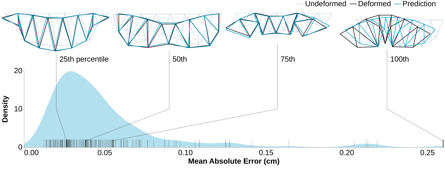

In [3]:
FIGH = 700
trussWidth = COLW/4
chartData = []

# mae percentiles (IN METERS)
df['Percentile'] = df.mae.rank(pct=True)
df = df.sort_values('Percentile')
percentileList = [0.25, 0.5, 0.75, 1.0]
indices = [df[df.Percentile >= p].index[0] for p in percentileList]
maes = [df[df.Percentile >= p].mae.values[0] for p in percentileList]
df['selected'] = False
df.loc[indices,'selected'] = True

# probability density plot
pdf = alt.Chart(df).transform_density(
    'mae',
    as_=['mae', 'density'],
    steps=1000,
    extent=[0,df.mae.max()],
#     bandwidth = 6e-5
).mark_area(opacity=0.3, color='#0096C7').encode(
    x=alt.X("mae:Q", title='Mean Absolute Error (cm)', axis=alt.Axis(grid=False, tickCount=6)),
    y=alt.Y('density:Q', title='Density', axis=alt.Axis(
        grid=False, tickCount=2, titlePadding=20), scale=alt.Scale(domain=[0,20]))
)

# strip plot
df['zeros'] = 0
stripPlot = alt.Chart(df).mark_tick(size=30, yOffset=-15, color='#000000', stroke='#000000').encode(
    x='mae:Q',
    y='zeros:Q',
    opacity=alt.Opacity('selected:N', legend=None, scale=alt.Scale(range=[0.2, 1.0])),
    strokeWidth=alt.StrokeWidth('selected:N', legend=None, scale=alt.Scale(range=[1, 1.1])),
)

# lines
trussPos = np.array([0.00020, 0.00090, 0.00157, 0.00225])*100
nLines = len(percentileList)
dfLines = pd.DataFrame({'line':np.linspace(0,nLines-1,num=nLines).repeat(3), 'point':['start', 'mid', 'end']*nLines})
dfLines.loc[dfLines.point=='start', 'x'] = maes
dfLines.loc[dfLines.point=='start', 'y'] = 1.7
dfLines.loc[dfLines.point=='mid', 'x'] = trussPos
dfLines.loc[dfLines.point=='mid', 'y'] = 10
dfLines.loc[dfLines.point=='end', 'x'] = trussPos
dfLines.loc[dfLines.point=='end', 'y'] = 27
lines = alt.Chart(dfLines).mark_line(color='#000000', strokeWidth=2.0, opacity=0.3).encode(
    x=alt.X('x:Q'),
    y=alt.Y('y:Q'),
    detail='line',
    order='point'
)

# percentile labels
pctLabelDf = pd.DataFrame({'text': [f'{int(pct*100)}th' for pct in percentileList], 
                           'x': trussPos+0.002})
pctLabelDf = pctLabelDf.replace('25th', '25th percentile')
pctLabelDf['y'] = 22
pctLabels = alt.Chart(pctLabelDf).mark_text(
    size=30, align='left', baseline='bottom').encode(x='x:Q', y='y:Q', text="text:N").properties(width=trussWidth)

distPlot = alt.layer(pdf,stripPlot,lines,pctLabels, background='white').configure_axis(
    labelFontSize=30, titleFontSize=30).properties(
    width=COLW, height=600).configure_view(
    strokeOpacity=0)
distPlot.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartData.append([distPlot, [0, FIGH-650+15]])

i=0
trussY = 30
for p,ind in zip(percentileList, indices):
    t = plotTruss(testData[ind], 
                  showDeformed=True, 
                  prediction=predictions[ind], 
                  defScale=300, 
                  brightColor='#0096C7',
                  width=trussWidth, 
                  lineWidth=2)
    chartData.append([t, [i*trussWidth,trussY+15]])
    i+=1

# legend
dfColors = pd.DataFrame({'x': [1,2,3]})
legend = alt.Chart(dfColors, background='none').mark_line().encode(
    color=alt.Color('x:N', scale=alt.Scale(
        range=['#C7D5E5', '#000000', '#0096C7'], 
        domain=['Undeformed', 'Deformed','Prediction']), 
        title=None, legend=alt.Legend(labelFontSize=30, symbolStrokeWidth=2, symbolSize=800, 
                    labelLimit=0, orient='top', direction='horizontal', rowPadding=0))
).configure_view(strokeOpacity=0).properties(
width=600, height=0)
legend.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartData.append([legend, [COLW-600,-5]])
    
chartsToFigure(chartData, figName='errorPlot', baseDir='figures', canvasSize=[COLW, FIGH])

# Samples from several groups

In [2]:
noms = {}
noms['5'] = loadConmechGraphs('data/2D_Truss_v1.3/conmech/param_sweep_0_5_N_5/')[2]
noms['6'] = loadConmechGraphs('data/2D_Truss_v1.3/conmech/param_sweep_0_6_N_5/')[2]
noms['7'] = loadConmechGraphs('data/2D_Truss_v1.3/conmech/param_sweep_0_7_N_5/')[2]
noms['8'] = loadConmechGraphs('data/2D_Truss_v1.3/conmech/param_sweep_0_8_N_5/')[2]
noms['9'] = loadConmechGraphs('data/2D_Truss_v1.3/conmech/param_sweep_0_9_N_5/')[2]

noms['el'] = loadConmechGraphs('data/endLoadsv1.0/conmech/param_sweep_0_7_N_5/')[2]
noms['tw'] = loadConmechGraphs('data/tower1.0/conmech/param_sweep_0_5_N_5/', loadDims=[0])[2]
noms['bd'] = loadConmechGraphs('data/djmmBridge1.0/conmech/param_sweep_0_N_5/')[2]

noms['elTest'] = loadConmechGraphs('data/endLoadsv1.0/conmech/design_7_N_1000')[5]
noms['twTest'] = loadConmechGraphs('data/tower1.0/conmech/design_5_N_1000', loadDims=[0])[3]
noms['bdTest'] = loadConmechGraphs('data/djmmBridge1.0/conmech/bridge_N_1000/')[3]

# load data
doeDirs = np.sort(glob.glob('data/2D_Truss_v1.3/conmech/*1000/'))
trainSets ,valSets ,testSets = {}, {}, {}
for doeDir in doeDirs:
    designName = doeDir.split('/')[-2].split('_N')[0]
    designNum = designName.split('_')[-1]
    print(f'loading {designName}')
    allGraphsUnfiltered = loadConmechGraphs(doeDir)
    allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
    trainData, valData, testData = partitionGraphList(allGraphs)
    testData = [noms[designNum]] + testData # make the first design the nominal one
    trainSets[designName] = trainData
    valSets[designName] = valData
    testSets[designName] = testData

loading design_5
loading design_6
loading design_7
loading design_8
loading design_9


(1781, 1500)


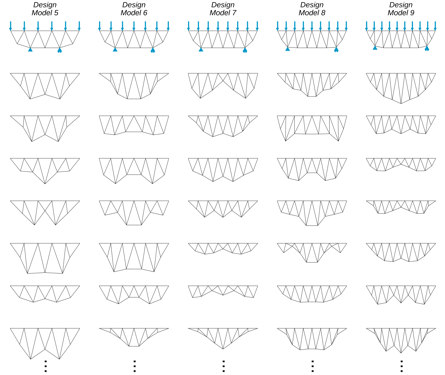

In [34]:
chartData = []
FIGH = 1500
trussWidth = 300

# ellipses
ellipses = alt.Chart({'values': [{"text": '...'}]},
).mark_text(size=70, align='center', font='Arial', baseline='middle', angle=90, dx=0, dy=0).encode(
    text="text:N"
).properties(width=trussWidth).configure_view(strokeOpacity=0)
ellipses.autosize = alt.AutoSizeParams(contains='padding', type='fit')

for it,(testName,testSet) in enumerate(testSets.items()):
    colX = it*COLW/5 + 30
    # make design model label
    title = alt.Chart(
        {'values': [{"text": 'Design\nModel '+testName.split('_')[-1]}]}
    ).mark_text(size=30, align='center', font='Arial', fontStyle='italic', lineBreak='\n').encode(
        text="text:N").properties(width=trussWidth).configure_view(strokeOpacity=0)
    title.autosize = alt.AutoSizeParams(contains='padding', type='fit')
    chartData.append([title, [colX,10]])
    
    for i,g in enumerate(testSet[:8]):
        rowY = 170*i+80
        truss = plotTruss(g, 
                          width=trussWidth, 
                          domX=[-1,51], 
                          domY=[-24.5,0+7] , 
                          lineWidth=1,
                          showLoads=(i==0),
                          loadSize=600,
                          supportSize=1000,
                          showSupports=(i==0))
        truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
        chartData.append([truss, [colX, rowY]])
    i +=1
    rowY = 170*i+80
    chartData.append([ellipses, [colX+20, rowY]])
    
chartsToFigure(chartData, figName='multitopoSamples', baseDir='figures', canvasSize=[COLW, FIGH])

# Single design icons

(1781, 445)
(1781, 445)
(1781, 445)
(1781, 445)
(1781, 445)
(1781, 470)
(1781, 675)
(1781, 1318)
(1781, 1318)
(1781, 1318)
(445, 1169)
(445, 1169)
(1781, 513)
(1781, 513)


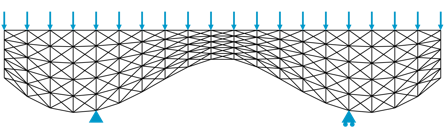

In [3]:
# ICONW = COLW/10
ICONW = COLW
LOADSIZE = 4e4
SUPPORTSIZE = 6e4
LINEWIDTH = 15

truss = plotTruss(noms['5'], width=ICONW, lineWidth=LINEWIDTH, background='none')
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='dm5', baseDir='figures')

truss = plotTruss(noms['6'], width=ICONW, lineWidth=LINEWIDTH, background='none')
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='dm6', baseDir='figures')

truss = plotTruss(noms['7'], width=ICONW, lineWidth=LINEWIDTH, background='none')
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='dm7', baseDir='figures')

truss = plotTruss(noms['8'], width=ICONW, lineWidth=LINEWIDTH, background='none')
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='dm8', baseDir='figures')

truss = plotTruss(noms['9'], width=ICONW, lineWidth=LINEWIDTH, background='none')
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='dm9', baseDir='figures')

# DM9 test
truss = plotTruss(testSets['design_9'][2], width=ICONW, lineWidth=LINEWIDTH, background='none')
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='dm9Test', baseDir='figures')

# DM5 test
truss = plotTruss(testSets['design_5'][2], width=ICONW, lineWidth=LINEWIDTH, background='none')
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='dm5Test', baseDir='figures')

# with loads
truss = plotTruss(noms['7'], width=ICONW, lineWidth=LINEWIDTH, background='none', showSupports=True, showLoads=True, loadSize=LOADSIZE, supportSize=SUPPORTSIZE, domY=[-27,10])
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='dm7Loads', baseDir='figures')

# endloads
truss = plotTruss(noms['el'], width=ICONW, lineWidth=LINEWIDTH, background='none', showSupports=True, showLoads=True, loadSize=LOADSIZE, supportSize=SUPPORTSIZE, domY=[-27,10])
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='endloads', baseDir='figures')

# endloads test
truss = plotTruss(noms['elTest'], width=ICONW, lineWidth=LINEWIDTH*3/4, background='none', showSupports=True, showLoads=True, loadSize=LOADSIZE, supportSize=SUPPORTSIZE, domY=[-27,10])
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='endloadsTest', baseDir='figures')

# tower
truss = plotTruss(noms['tw'], width=ICONW/4, lineWidth=LINEWIDTH*3/4, background='none', showSupports=True, showLoads=True, loadSize=LOADSIZE*3/10, supportSize=SUPPORTSIZE/2, domX=[-10, 30], domY=[-20, 85], loadTheta=0)
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='tower', baseDir='figures')

# tower test
truss = plotTruss(noms['twTest'], width=ICONW/4, lineWidth=LINEWIDTH, background='none', showSupports=True, showLoads=True, loadSize=LOADSIZE*3/10, supportSize=SUPPORTSIZE/2, domX=[-10, 30], domY=[-20, 85], loadTheta=0)
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='towerTest', baseDir='figures')

# bridge
truss = plotTruss(noms['bd'], width=ICONW, lineWidth=LINEWIDTH/5, showLoads=True, background='none', showSupports=True, domY=[-85.2, 30], loadSize=LOADSIZE*3/50, supportSize=SUPPORTSIZE*10/50)
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='bridge', baseDir='figures')

# bridge test
truss = plotTruss(noms['bdTest'], width=ICONW, lineWidth=LINEWIDTH/5, showLoads=True, background='none', showSupports=True, domY=[-85.2, 30], loadSize=LOADSIZE*3/50, supportSize=SUPPORTSIZE*10/50)
truss.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartsToFigure(truss, figName='bridgeTest', baseDir='figures')

# Multi-Topology Studies

In [74]:
df = pd.read_csv('results/topoTest05/testResults.csv')
df = df.replace('design_5', 'DM 5')
df = df.replace('design_6', 'DM 6')
df = df.replace('design_7', 'DM 7')
df = df.replace('design_8', 'DM 8')
df = df.replace('design_9', 'DM 9')
df = df.replace('test group', 'target DM (Trial A)')
df = df.replace('all groups', 'all DMs (Trial B)')
df = df.replace('all groups but test group', 'all DMs but target DM (Trial C)')
df = df.replace('transfer learning (20%)', 'transfer learning (Trial D)')

#CONVERT TO CM
df.mae = df.mae * 30.48 
df.mse = df.mse * 30.48**2 

order = ['test group', 'all groups']
barChart = alt.Chart(df).mark_bar().encode(
    x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False)),
    y=alt.Y('mean(mae):Q', axis=alt.Axis(tickCount=8, format=".0e"), scale=alt.Scale(clamp=True), title='Mean Absolute Error (cm)'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='bottom')),
    opacity = alt.OpacityValue(0.8),
).properties(width=75, height=200)

scatter = alt.Chart(df).mark_circle(size=20).encode(
    x=alt.X('Trained on:N', title='', sort=order),
    y=alt.Y('mae:Q'),
    color=alt.Color('Trained on:N', sort=order),
    opacity = alt.OpacityValue(0.3),
)

alt.layer(barChart, scatter, data=df).facet(
    column=alt.Column('Tested on:N', title=''), align='none')

alt.FacetChart(...)

In [79]:
order = ['test group', 'all groups']
boxplot = alt.Chart(df).mark_boxplot(outliers=False, median=False, box=False, ticks=True).encode(
    x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False)),
    y=alt.Y('mean(mae):Q', axis=alt.Axis(tickCount=8, format=".0e"), scale=alt.Scale(clamp=True), title='Mean Absolute Error (cm)'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='bottom')),
    opacity = alt.OpacityValue(0.8),
).properties(width=75, height=200)

scatter = alt.Chart(df).mark_circle(size=20).encode(
    x=alt.X('Trained on:N', title='', sort=order),
    y=alt.Y('mae:Q'),
    color=alt.Color('Trained on:N', sort=order),
    opacity = alt.OpacityValue(0.3),
)

alt.layer(barChart, scatter, boxplot, data=df).facet(
    column=alt.Column('Tested on:N', title=''), align='none')

alt.FacetChart(...)

In [146]:
boxplot = alt.Chart(df).mark_boxplot(outliers=False, median=False, 
                                     ticks=False,
                                     rule=alt.MarkConfig(color='#BFC0C0'), 
#                                      ticks=False,
#                                      rule=False,
                                     extent=0.5,
                                     box=alt.MarkConfig(filled=False)).encode(
    x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False)),
    y=alt.Y('mae:Q', axis=alt.Axis(grid=False), title='Mean Absolute Error (cm)'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='bottom')),
    opacity = alt.OpacityValue(0.8),
).properties(width=75, height=200)

means = alt.Chart(df).mark_tick(
    thickness=3,
).encode(
    x='Trained on:N',
    y='mean(mae):Q',
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='bottom')),
).properties(width=75, height=200)

alt.layer(means, boxplot, data=df).facet(
    column=alt.Column('Tested on:N', title=''), align='none', spacing=15,).configure_view(strokeOpacity=0).resolve_scale(x='independent')

alt.FacetChart(...)

In [148]:
barChart = alt.Chart(df).mark_bar().encode(
    x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False)),
    y=alt.Y('mean(mae):Q', axis=alt.Axis(), scale=alt.Scale(), title='Mean Absolute Error (cm)'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='bottom')),
    opacity = alt.OpacityValue(0.8),
).properties(width=75, height=200)

boxplot = alt.Chart(df).mark_boxplot(outliers=False, median=False, 
                                     ticks=alt.MarkConfig(color='#BFC0C0', opacity=1),
                                     rule=False, 
                                     extent=0.5,
                                     box=False).encode(
    x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False)),
    y=alt.Y('mae:Q', axis=alt.Axis(grid=False), title='Mean Absolute Error (cm)'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='bottom')),
    opacity = alt.OpacityValue(0.8),
)

alt.layer(barChart, boxplot, data=df).facet(
    column=alt.Column('Tested on:N', title=''), align='none', spacing=15,).configure_view(strokeOpacity=0).resolve_scale(x='independent')

alt.FacetChart(...)

In [67]:
order = ['test group', 'all groups']
barChart = alt.Chart(df).transform_calculate(
    X="datum['Trained on'] + '-' + datum['Tested on']"
).mark_bar().encode(
    x=alt.X('X:N', sort=order, title='', axis=alt.Axis()),
    y=alt.Y('mean(mae):Q', axis=alt.Axis(tickCount=8, format=".0e"), scale=alt.Scale(), title='Mean Absolute Error (m)'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='top')),
    opacity = alt.OpacityValue(0.8),
    detail='Tested on'
).properties(width=600, height=200)
barChart

alt.Chart(...)

In [74]:
order = ['test group', 'all groups']
barChart = alt.Chart(df).mark_bar().encode(
    column = alt.Column('Tested on:N', title='', align='none', spacing=15),
    x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False, grid=False)),
    y=alt.Y('mean(mae):Q', axis=alt.Axis(tickCount=8, format=".0e", grid=False), scale=alt.Scale(), title='Mean Absolute Error (m)'),
    color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='top')),
    opacity = alt.OpacityValue(0.8),
    tooltip='mean(mae):Q'
).properties(width=75, height=200)

# dummy = alt.Chart(df).mark_bar().encode(
#     column = alt.Column('Tested on:N', title='', align='none', spacing=15),
#     x=alt.X('Trained on:N', sort=order, title='', axis=alt.Axis(ticks=False, labels=False, grid=False)),
#     y=alt.Y('mean(mae):Q', axis=alt.Axis(tickCount=8, format=".0e", grid=False), scale=alt.Scale(), title='Mean Absolute Error (m)'),
#     color=alt.Color('Trained on:N', sort=order, legend=alt.Legend(orient='top')),
#     opacity = alt.OpacityValue(0.8),
#     tooltip='mean(mae):Q'
# ).properties()

fig = alt.layer(barChart).configure_view(strokeWidth=0)
barChart.autosize = alt.AutoSizeParams(contains='padding', type='fit')
barChart.configure_view(strokeWidth=0)

ValueError: Faceted charts cannot be layered.

# Tranfer learning studies

(1781, 800)


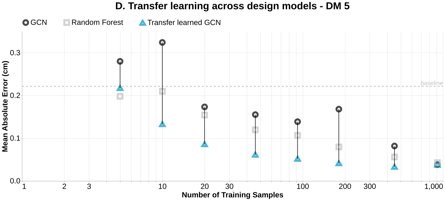

In [49]:
def tlScatterPlot(df, figName, title, showLines=True, baseline=None):
    FIGH = 800
    chartList = []
    
    if baseline:
        # baseline
        baselineFig = alt.Chart(pd.DataFrame({'Train Size':[1,1000], 'mae':baseline})).mark_line(color='#BFC0C0', 
                strokeDash=[8,8], strokeWidth=3, opacity=1).encode(
            x=alt.X('Train Size:Q', scale=alt.Scale(type='log')),
            y=alt.Y('mae:Q'),
        )

        baselineLabel = alt.Chart(pd.DataFrame({"text": 'baseline', 'Train Size':1000, 'mae':baseline}, index=[0])).mark_text(
            size=24, align='right', baseline='bottom', color='#BFC0C0', opacity=1).encode(
            x='Train Size',
            y='mae',
            text="text:N"
        ).properties()

        chartList += [baselineFig, baselineLabel]
    
    df = df.replace('Fresh', 'GCN')
    df = df.replace('Transfer learning', 'Transfer learned GCN')
    #CONVERT TO CENTIMETERS
    df.mae = df.mae * 30.48 

    # parse data
    dfFresh = df.loc[(df['Model']=='GCN') & (df['Set']=='Test'), ['mae','Train Size']]
    dfTL = df.loc[(df['Model']=='Transfer learned GCN') & (df['Set']=='Test'), ['mae','Train Size']]
    dfComb = dfFresh.merge(dfTL, on='Train Size', suffixes=['_fresh', '_tl'])
    df = df.loc[df.Set=='Test']

    # lines
    lines = alt.Chart(dfComb).mark_rule(strokeWidth=2).encode(
        x=alt.X('Train Size:Q', scale=alt.Scale(type='log'), title='Number of Training Samples'),
        y=alt.Y('mae_fresh:Q', title='Mean Absolute Error (cm)', axis=alt.Axis()),
        y2=alt.Y2('mae_tl:Q'),
        color=alt.condition('datum.mae_fresh > datum.mae_tl', alt.ColorValue('black'), alt.ColorValue('red'))
    ).properties(width=COLW, height=FIGH)

    # scatter plot
    scatter = alt.Chart(df[(df.Set=='Test')]).mark_point(size=350, strokeWidth=8).encode(
        x=alt.X('Train Size:Q', scale=alt.Scale(type='log'), axis=alt.Axis(grid=True), title='Number of Training Samples'),
        y=alt.Y('mae:Q', title='Mean Absolute Error (cm)', axis=alt.Axis(grid=True, tickCount=3)),
        color=alt.Color('Model', scale=alt.Scale(range=['black', '#BFC0C0', '#0096C7']), legend=alt.Legend(
            orient='top', title='', labelLimit=0, symbolSize=350, symbolStrokeWidth=8, columnPadding=60)),
        shape=alt.Shape('Model')
    ).properties(width=COLW, height=FIGH)
    chartList += [scatter] 
    if showLines: chartList += [lines]
    
    chartData = alt.layer(*chartList).configure_view(
        strokeOpacity=0).configure_axis(
        labelFontSize=30, titleFontSize=30).configure_legend(
        labelFontSize=30, titleFontSize=30).properties(
        title=title).configure_title(
        fontSize=40, offset=30)
    chartData.autosize = alt.AutoSizeParams(contains='padding', type='fit')
    return chartsToFigure(chartData, figName=figName, baseDir='figures')

def getBaseline(trainDir, testDir):
    allGraphsUnfiltered = loadConmechGraphs(trainDir)
    trainData = filterbyDisp(allGraphsUnfiltered, 0.9)

    allGraphsUnfiltered = loadConmechGraphs(testDir)
    testData = filterbyDisp(allGraphsUnfiltered, 0.9)

    base = baseline([g.y.cpu().numpy() for g in trainData], 
                    [g.y.cpu().numpy() for g in testData], 
                    level='set', avgLevel='point')
    return base

dataDir = "data/2D_Truss_v1.3/conmech/"
trainDir = os.path.join(dataDir, 'design_5_N_1000_v2/')
testDir = os.path.join(dataDir, 'design_5_N_1000/')
base = getBaseline(trainDir, testDir)['mae']
base *= 30.48  #CONVERT TO CM

df = pd.read_csv('results/transferLrn_des5_04/testResults.csv')
tlScatterPlot(df, 'tlDes5', 'D. Transfer learning across design models - DM 5', baseline=base)

(1781, 800)


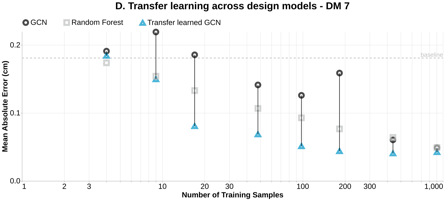

In [50]:
dataDir = "data/2D_Truss_v1.3/conmech/"
trainDir = os.path.join(dataDir, 'design_7_N_1000_v2/')
testDir = os.path.join(dataDir, 'design_7_N_1000/')
base = getBaseline(trainDir, testDir)['mae']
base *= 30.48  #CONVERT TO CM

df = pd.read_csv('results/transferLrn_des7_04/testResults.csv')
tlScatterPlot(df, 'tlDes7', 'D. Transfer learning across design models - DM 7', baseline=base)

(1781, 800)


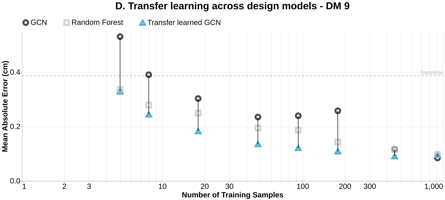

In [54]:
dataDir = "data/2D_Truss_v1.3/conmech/"
trainDir = os.path.join(dataDir, 'design_9_N_1000_v2/')
testDir = os.path.join(dataDir, 'design_9_N_1000/')
base = getBaseline(trainDir, testDir)['mae']
base *= 30.48  #CONVERT TO CM

df = pd.read_csv('results/transferLrn_des9_04/testResults.csv')
tlScatterPlot(df, 'tlDes9', 'D. Transfer learning across design models - DM 9', baseline=base)

(1781, 800)


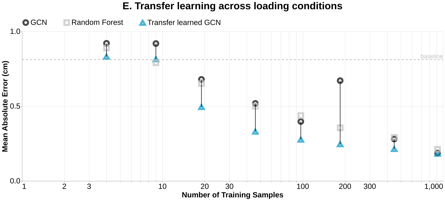

In [56]:
dataDir = "data/endLoadsv1.0/conmech/"
trainDir = os.path.join(dataDir, 'design_7_N_1000_v2/')
testDir = os.path.join(dataDir, 'design_7_N_1000/')
base = getBaseline(trainDir, testDir)['mae']
base *= 30.48  #CONVERT TO CM

df = pd.read_csv('results/transferLrn_endloads_des7_02/testResults.csv')
tlScatterPlot(df, 'tlEndload', 'E. Transfer learning across loading conditions', baseline=base)

(1781, 800)


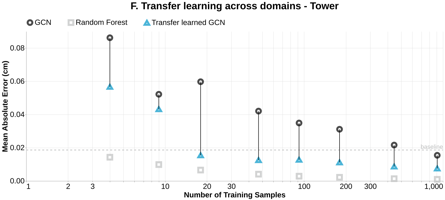

In [57]:
dataDir = "data/tower1.0/conmech/"
trainDir = os.path.join(dataDir, 'design_5_N_1000_v2/')
testDir = os.path.join(dataDir, 'design_5_N_1000/')
base = getBaseline(trainDir, testDir)['mae']
base *= 30.48  #CONVERT TO CM

df = pd.read_csv('results/transferLrn_des7_tower5_03/testResults.csv')
tlScatterPlot(df, 'tlTower', 'F. Transfer learning across domains - Tower', baseline=base)

# Error distribution comparisons

In [12]:
def getLossMetrics(modelFile, dataDir):
    # load model
    gcn = FeaStNet()
    gcn.loadModel(modelFile)

    # load data
    allGraphsUnfiltered = loadConmechGraphs(dataDir)
    allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
    trainData, valData, testData = partitionGraphList(allGraphs)

    # run inference
    predictions = gcn.predict(testData)
    resultsDictWide = computeFieldLossMetrics([g.y.cpu().numpy() for g in testData], 
                                  predictions, 
                                  baselineRef=None, level='field')
    resultsDict = [dict(zip(resultsDictWide,t)) for t in zip(*resultsDictWide.values())]
    df = pd.DataFrame(resultsDict)

    #CONVERT TO CENTIMETERS
    df.mae = df.mae * 30.48
    
    return df

# FRESH
modelFile = 'results/transferLrn_des7_04/00017/gcn/checkpoint_99'
dataDir = 'data/2D_Truss_v1.3/conmech/design_7_N_1000/'
dfFresh = getLossMetrics(modelFile, dataDir)

# TRANSFER LEARNING
modelFile = 'results/transferLrn_des7_04/00017/ptrGcn/checkpoint_68'
dfTl = getLossMetrics(modelFile, dataDir)

/data/anaconda/envs/ptgeom/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'gcnSurrogate.models.feastnetSurrogateModel.FeaStNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/data/anaconda/envs/ptgeom/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'gcnSurrogate.models.feastnetSurrogateModel.FeaStNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


(1781, 700)


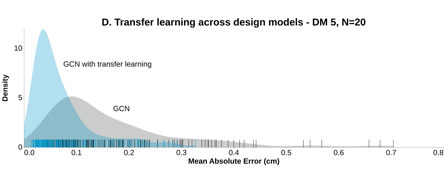

In [30]:
FIGH = 700
trussWidth = COLW/4
chartData = []

def makePdf(df, color='#0096C7'):
    pdf = alt.Chart(df).transform_density(
    'mae',
    as_=['mae', 'density'],
    steps=1000,
    extent=[0,df.mae.max()],
    #     bandwidth = 6e-5
    ).mark_area(opacity=0.3, color=color).encode(
        x=alt.X("mae:Q", title='Mean Absolute Error (cm)', axis=alt.Axis(grid=False, tickCount=6)),
        y=alt.Y('density:Q', title='Density', axis=alt.Axis(
            grid=False, tickCount=2, titlePadding=20), scale=alt.Scale())
    )
    return pdf

def makeStripPlot(df, color='#000000'):
    df['zeros'] = 0
    stripPlot = alt.Chart(df).mark_tick(size=30, yOffset=-15, stroke=color).encode(
        x='mae:Q',
        y='zeros:Q',
        opacity=alt.Opacity('selected:N', legend=None, scale=alt.Scale(range=[0.2, 1.0])),
        strokeWidth=alt.StrokeWidth('selected:N', legend=None, scale=alt.Scale(range=[1, 1.1])),
    )
    return stripPlot

def makeLabel(text, x, y):
    labelDf = pd.DataFrame({'text': [text], 
                           'x': [x], 'y':[y]})
    label = alt.Chart(labelDf).mark_text(
    size=30, align='left', baseline='bottom').encode(x='x:Q', y='y:Q', text="text:N").properties(width=trussWidth)
    return label

# fresh 
pdfFresh = makePdf(dfFresh, color='#515353')
stripPlotFresh = makeStripPlot(dfFresh)
labelFresh = makeLabel('GCN', 0.17, 3.5)

# transfer learning
pdfTl = makePdf(dfTl, color='#0096C7')
stripPlotTl = makeStripPlot(dfTl, color='#0096C7')
labelTl = makeLabel('GCN with transfer learning', 0.075, 8)

distPlot = alt.layer(pdfFresh, stripPlotFresh, labelFresh,
                     pdfTl, stripPlotTl, labelTl, background='white').configure_axis(
    labelFontSize=30, titleFontSize=30).properties(
    width=COLW, height=600).configure_view(
    strokeOpacity=0).properties(title='D. Transfer learning across design models - DM 5, N=20').configure_title(
fontSize=40)
distPlot.autosize = alt.AutoSizeParams(contains='padding', type='fit')
chartData.append([distPlot, [0, FIGH-650+15]])

chartsToFigure(chartData, figName='errorPlotTl_design_7_N_20', baseDir='figures', canvasSize=[COLW, FIGH])

# Training curves

In [22]:
trialDir = 'results/transferLrn_des7_tower5_03/00018/'
gcnHist = pd.read_csv(trialDir+'gcn/trainlog.csv', header=None, names=['epoch', 'train', 'val', 'time'])
gcnHist['trial'] = 'gcn'
ptrGcnHist = pd.read_csv(trialDir+'/ptrGcn/trainlog.csv', header=None, names=['epoch', 'train', 'val', 'time'])
ptrGcnHist['trial'] = 'ptrGcn'
df = pd.concat([gcnHist, ptrGcnHist], axis=0)

fig = alt.Chart(df).transform_fold(
            ['train', 'val'],
            as_=['set', 'value']
            ).mark_line(clip=True).encode(
                alt.X('epoch:Q', axis=alt.Axis(grid=False),),
                alt.Y('value:Q', axis=alt.Axis(title='loss', grid=False), scale=alt.Scale(domain=[0,2])),
                color=alt.Color('trial:N'),
                strokeDash = alt.StrokeDash('set:N', sort=['val', 'train']),
                tooltip=['epoch:Q', 'value:Q']
            ).properties(width=400, height=200).configure_view(strokeOpacity=0)
fig

alt.Chart(...)

In [28]:
trialDir = 'results/transferLrn_des7_tower5_03/00018/'
gcnHist = pd.read_csv(trialDir+'gcn/trainlog.csv', header=None, names=['epoch', 'train', 'val', 'time'])
gcnHist['trial'] = 'gcn'
ptrGcnHist = pd.read_csv(trialDir+'/ptrGcn/trainlog.csv', header=None, names=['epoch', 'train', 'val', 'time'])
ptrGcnHist['trial'] = 'ptrGcn'
df = pd.concat([gcnHist, ptrGcnHist], axis=0)

fig = alt.Chart(df).transform_fold(
            ['train', 'val'],
            as_=['set', 'value']
            ).mark_line(clip=True).encode(
                alt.X('epoch:Q', axis=alt.Axis(grid=False),),
                alt.Y('value:Q', axis=alt.Axis(title='loss', grid=False), scale=alt.Scale(domaintype='log')),
                color=alt.Color('trial:N'),
                strokeDash = alt.StrokeDash('set:N', sort=['val', 'train']),
                tooltip=['epoch:Q', 'value:Q']
            ).properties(width=400, height=200).configure_view(strokeOpacity=0)
fig

alt.Chart(...)

# Towers

image size: (1625, 1269)


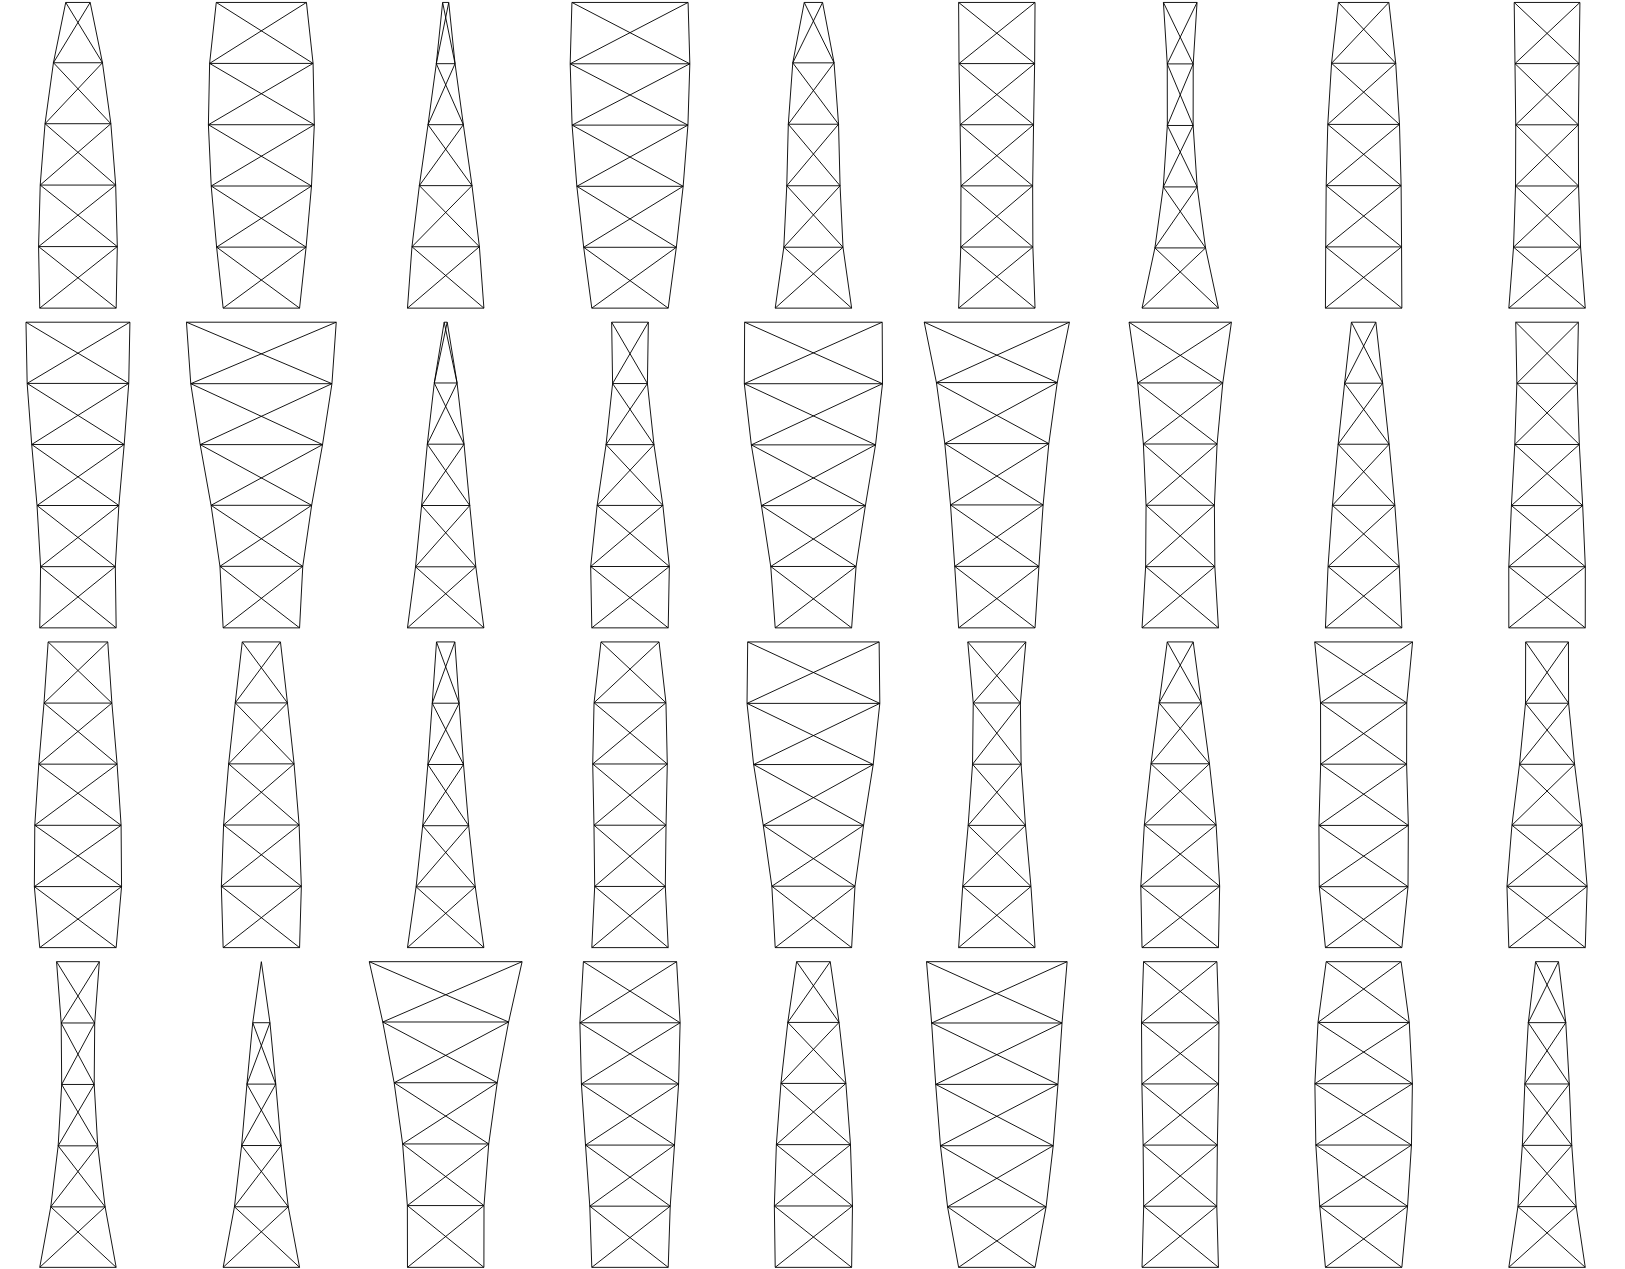

In [4]:
nModels = 36
nRows = 4
plotList = [plotTruss(g, 
                      width=500, 
                      domX=[-10,30], 
                      domY=[30,80], 
                      lineWidth=3, 
                      withoutConfigure=True, 
                      baseColor='#000000') for g in allGraphs[:nModels]]
columnList = [alt.vconcat(*plotList[nRows*i:nRows*(i+1)], spacing=40) for i in range(int(nModels/nRows))]
fig = alt.hconcat(*columnList, spacing=100, background='white').configure_view(strokeOpacity=0)

saveAsImage(fig, 'figures/tower5Samples.png', widthInches=3.25, dpi=500)